In [ ]:
import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import math
import statistics

#%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

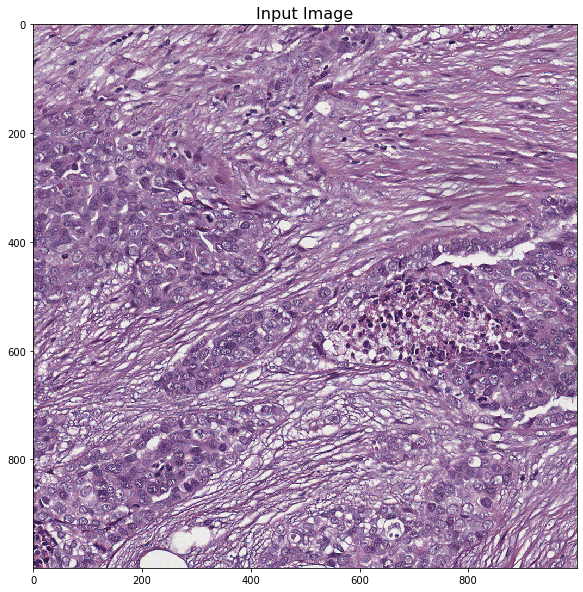

In [ ]:
input_image_file ="/home/arraygen/Desktop/OUT_PUT/part74.png"
out_file_path="/home/arraygen/Desktop/OUTPUT.txt"

im_input = skimage.io.imread(input_image_file)[:, :, :3]

plt.imshow(im_input)
_ = plt.title('Input Image', fontsize=16)

(792, 1650, 3)
(1000, 1000, 3)


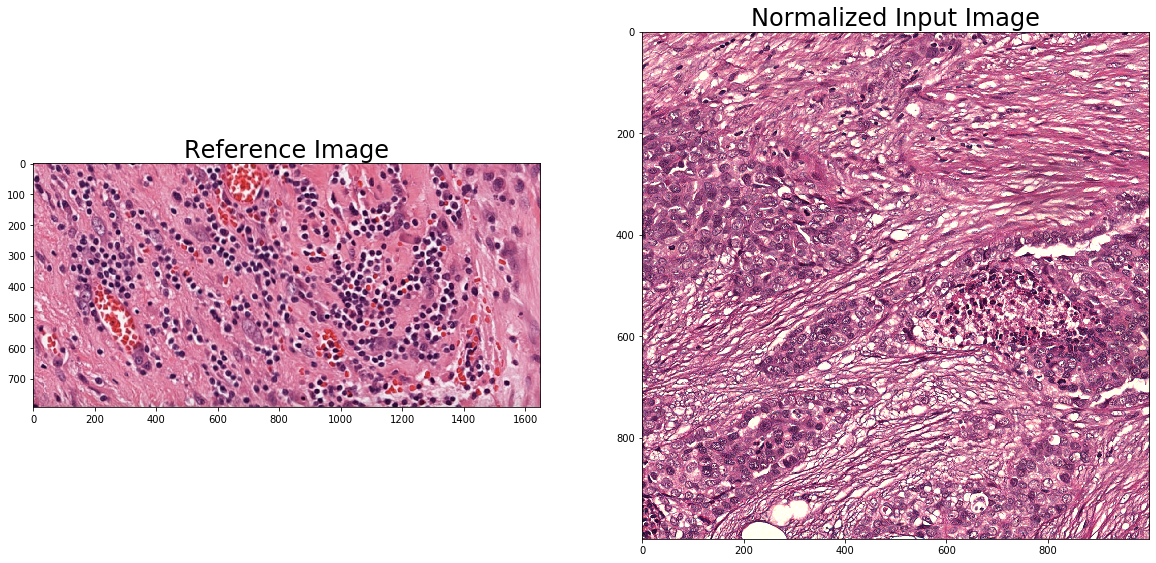

In [ ]:
# Load reference image for normalization
ref_image_file = ('https://data.kitware.com/api/v1/file/'
                  '57718cc28d777f1ecd8a883c/download')  # L1.png

im_reference = skimage.io.imread(ref_image_file)[:, :, :3]

# get mean and stddev of reference image in lab space
mean_ref, std_ref = htk.preprocessing.color_conversion.lab_mean_std(im_reference)

# perform reinhard color normalization
im_nmzd = htk.preprocessing.color_normalization.reinhard(im_input, mean_ref, std_ref)

print(im_reference.shape)
print(im_nmzd.shape)

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_reference)
_ = plt.title('Reference Image', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_nmzd)
_ = plt.title('Normalized Input Image', fontsize=titlesize)

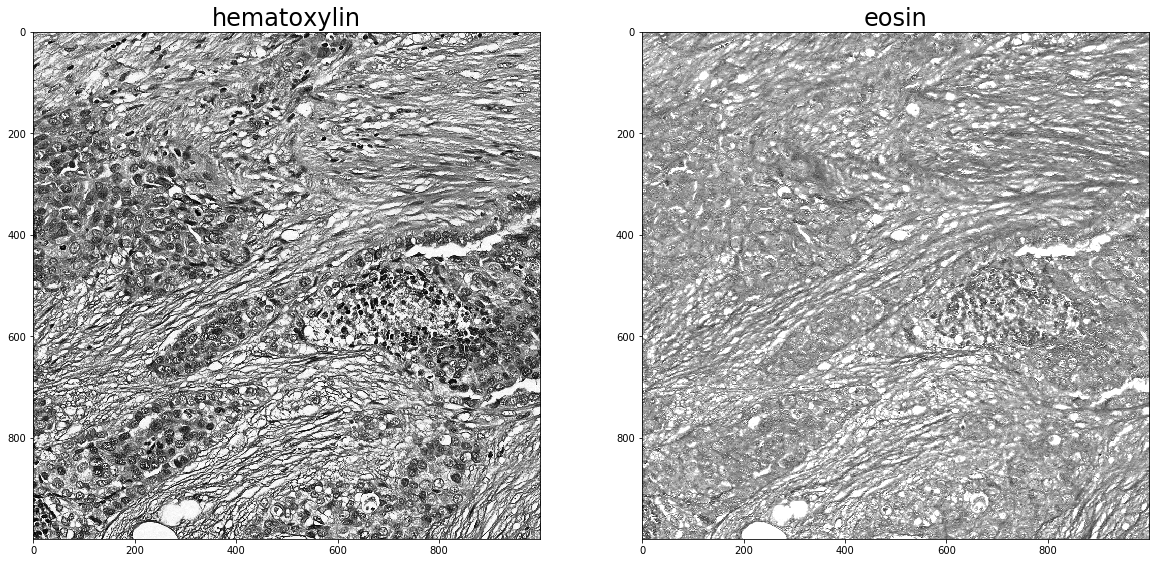

In [ ]:
# create stain to color map
stainColorMap = {
    'hematoxylin': [0.65, 0.70, 0.29],
    'eosin':       [0.07, 0.99, 0.11],
    'dab':         [0.27, 0.57, 0.78],
    'null':        [0.0, 0.0, 0.0]
}

# specify stains of input image
stain_1 = 'hematoxylin'   # nuclei stain
stain_2 = 'eosin'         # cytoplasm stain
stain_3 = 'null'          # set to null of input contains only two stains

# create stain matrix
W = np.array([stainColorMap[stain_1],
              stainColorMap[stain_2],
              stainColorMap[stain_3]]).T

# perform standard color deconvolution
im_stains = htk.preprocessing.color_deconvolution.color_deconvolution(im_nmzd, W).Stains

# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(im_stains[:, :, 0])
plt.title(stain_1, fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow(im_stains[:, :, 1])
_ = plt.title(stain_2, fontsize=titlesize)

Number of nuclei =  287
Nuclear Area :  91
Major Axis Length :  30.633439036147394
Minor Axis Length :  11.125432170459318
ratio of major to minor axis length :  15316719518.073696  to  5562716085.229659
<class 'skimage.measure._regionprops._RegionProperties'>
7.802197802197802
(7.802197802197802, 387.4835164835165)
(12.096069868995633, 664.0436681222708)
(7.802197802197802, 387.4835164835165)
Minimum distance to cell 51.65180111901193
Maximum distance to cell 1136.528487202504
Mean Distance to cell 650.0452745762441
(12.096069868995633, 664.0436681222708)
Minimum distance to cell 53.60634785942746
Maximum distance to cell 1175.1283353549195
Mean Distance to cell 674.6698181247741
(10.53763440860215, 868.9462365591398)
Minimum distance to cell 69.74390928597887
Maximum distance to cell 1301.4461021768761
Mean Distance to cell 760.9436974101003
(12.371621621621621, 521.2668918918919)
Minimum distance to cell 49.54518496639458
Maximum distance to cell 1101.8925273962002
Mean Distance to 

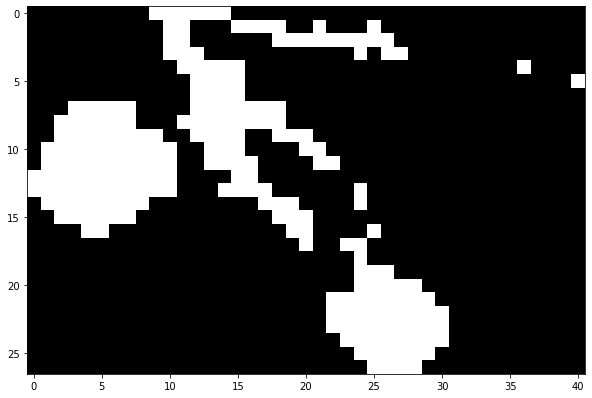

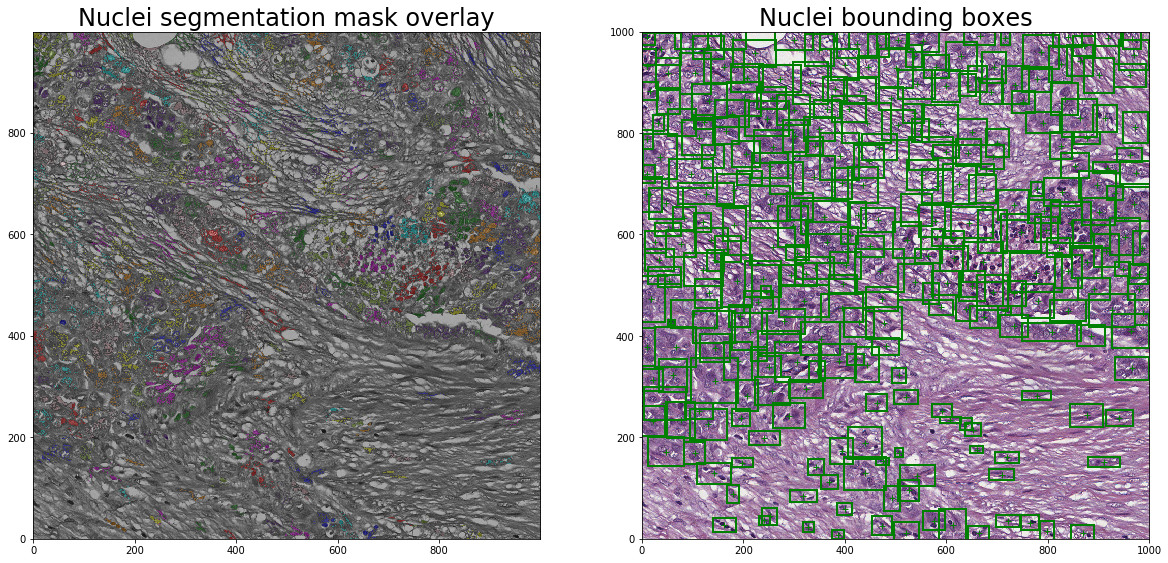

In [ ]:



fw=open(out_file_path,"w")
# get nuclei/hematoxylin channel
im_nuclei_stain = im_stains[:, :, 0]

# segment foreground
foreground_threshold = 60

im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
    im_nuclei_stain < foreground_threshold)

# run adaptive multi-scale LoG filter
min_radius = 10
max_radius = 15

im_log_max, im_sigma_max = htk.filters.shape.cdog(
    im_nuclei_stain, im_fgnd_mask,
    sigma_min=min_radius * np.sqrt(2),
    sigma_max=max_radius * np.sqrt(2)
)

# detect and segment nuclei using local maximum clustering
local_max_search_radius = 10

im_nuclei_seg_mask, seeds, maxima = htk.segmentation.nuclear.max_clustering(
    im_log_max, im_fgnd_mask, local_max_search_radius)

# filter out small objects
min_nucleus_area = 80

im_nuclei_seg_mask = htk.segmentation.label.area_open(
    im_nuclei_seg_mask, min_nucleus_area).astype(np.int)

# compute nuclei properties
objProps = skimage.measure.regionprops(im_nuclei_seg_mask)

print ('Number of nuclei = ', len(objProps))





MAL=objProps[0].major_axis_length
MiAL=objProps[0].minor_axis_length

# Calculate Ratio:-
dec_ele_mal=MAL*10**9
dec_ele_minor=MiAL*10**9
    
GCF_MAL=dec_ele_mal/2
GCF_Mial=dec_ele_minor/2




print("Nuclear Area : ",objProps[0].area)
print("Major Axis Length : ",MAL)
print("Minor Axis Length : ",MiAL)
print("ratio of major to minor axis length : ",GCF_MAL," to ",GCF_Mial)



print(type(objProps[0]))
print(objProps[0].centroid[0])

ndar1=objProps[0].image
plt.imshow(ndar1)

ndar1=objProps[1].image
plt.imshow(ndar1)

print(objProps[0].centroid)
print(objProps[1].centroid)

"""
dist_list=[]

x1,y1=objProps[0].centroid
x2,y2=objProps[1].centroid


# Calculate Distance Between two Pixcel Or Cell
dist=math.sqrt((y2-y1)**2+(x2-x1)**2)
print("Distance Bet two Cell",dist)
dist_list.append(dist)

#  no 0 cell to all other cells
x2,y2=objProps[2].centroid
# Calculate Distance Between two Pixcel Or Cell
dist=math.sqrt((y2-y1)**2+(x2-x1)**2)
print("Distance Bet two Cell",dist)
dist_list.append(dist)


#  no 0 cell to all other cells
x2,y2=objProps[3].centroid
# Calculate Distance Between two Pixcel Or Cell
dist=math.sqrt((y2-y1)**2+(x2-x1)**2)
print("Distance Bet two Cell",dist)
dist_list.append(dist)


print(dist_list)
print("Minimum distance to cell",min(dist_list))
print("Maximum distance to cell",max(dist_list))

"""



# Display results
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(skimage.color.label2rgb(im_nuclei_seg_mask, im_input, bg_label=0), origin='lower')
plt.title('Nuclei segmentation mask overlay', fontsize=titlesize)

plt.subplot(1, 2, 2)
plt.imshow( im_input )
plt.xlim([0, im_input.shape[1]])
plt.ylim([0, im_input.shape[0]])
plt.title('Nuclei bounding boxes', fontsize=titlesize)

fw.write("Cell Centroid\t"+"Major Axis Length\t"+"Minor Axis Length\t"+"ratio of major to minor axis length\t"+"Nuclear Area\t"+"minimum distance to neighboring cells\t"+"maximum distance to neighboring cells\t"+"mean distance to neighboring cells"+"\n")

for i in range(len(objProps)):
    
    MAL=objProps[i].major_axis_length
    MiAL=objProps[i].minor_axis_length
    
    # Calculate Ratio:-
    dec_ele_mal=MAL*10**9
    dec_ele_minor=MiAL*10**9
    
    GCF_MAL=dec_ele_mal/2
    GCF_Mial=dec_ele_minor/2
    
    
    fw.write(str(objProps[i].centroid)+"\t")
    fw.write(str(MAL)+"\t") 
    fw.write(str(MiAL)+"\t")
    fw.write(str(GCF_MAL)+" to "+str(GCF_Mial)+"\t")
    fw.write(str(objProps[i].area)+"\t")
    
    

    c = [objProps[i].centroid[1], objProps[i].centroid[0], 0]
    width = objProps[i].bbox[3] - objProps[i].bbox[1] + 1
    height = objProps[i].bbox[2] - objProps[i].bbox[0] + 1

    cur_bbox = {
        "type":        "rectangle",
        "center":      c,
        "width":       width,
        "height":      height,
    }

    plt.plot(c[0], c[1], 'g+')
    #print(width,height)
    mrect = mpatches.Rectangle([c[0] - 0.5 * width, c[1] - 0.5 * height] ,
                               width, height, fill=False, ec='g', linewidth=2)
    plt.gca().add_patch(mrect)

    ###  For Finding Minimum Distance And Maximum Distance
    
    dist_list=[]
    
    x1,y1=objProps[i].centroid
    dist_list=[]
    print(objProps[i].centroid)
    
    for j in range(len(objProps)):
        if(i!=j):
            x2,y2=objProps[j].centroid
            dist=math.sqrt((y2-y1)**2+(x2-x1)**2)
            #print("Distance Bet two Cell",dist)
            dist_list.append(dist)

    #print(dist_list)
    print("Minimum distance to cell",min(dist_list))
    print("Maximum distance to cell",max(dist_list))
    print("Mean Distance to cell",statistics.mean(dist_list))
    
    fw.write(str(min(dist_list))+"\t")
    fw.write(str(max(dist_list))+"\t")
    fw.write(str(statistics.mean(dist_list))+"\n")
    


fw.close()

(7.802197802197802, 387.4835164835165)
Minimum distance to cell 51.65180111901193
Maximum distance to cell 1136.528487202504
(12.096069868995633, 664.0436681222708)
Minimum distance to cell 53.60634785942746
Maximum distance to cell 1175.1283353549195
(10.53763440860215, 868.9462365591398)
Minimum distance to cell 69.74390928597887
Maximum distance to cell 1301.4461021768761
(12.371621621621621, 521.2668918918919)
Minimum distance to cell 49.54518496639458
Maximum distance to cell 1101.8925273962002
(22.785714285714285, 328.3775510204082)
Minimum distance to cell 60.97557641825096
Maximum distance to cell 1155.2045471596505
(26.00729927007299, 473.6350364963504)
Minimum distance to cell 49.54518496639458
Maximum distance to cell 1078.9528385692615
(26.85645933014354, 162.89473684210526)
Minimum distance to cell 64.35338295843383
Maximum distance to cell 1251.045184474168
(27.454954954954953, 612.6846846846847)
Minimum distance to cell 37.61191913736678
Maximum distance to cell 1134.316